In [4]:
# Baixando
!pip install -U -q PyDrive

In [5]:
# Importando bibliotecas
import pandas as pd
import numpy as np
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from sklearn import datasets
from oauth2client.client import GoogleCredentials
from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.preprocessing import LabelEncoder #Scikit Learn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [6]:
# Autenticando para entrar no drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
# Baixando o arquivo de metadados
downloaded = drive.CreateFile({'id': '1AUBksb9ooahhbiqi1h0DoAhyPxpylpvo'})
downloaded.GetContentFile('book_variaveis_pan_inteli_v4.csv')
print(downloaded['title'], downloaded['mimeType'])

book_variaveis_pan_inteli_v4.csv text/csv


In [8]:
# Lendo os dados do arquivo
data = pd.read_csv('book_variaveis_pan_inteli_v4.csv')

In [9]:
# Seleção da safra do ano de 2021 no mês 11
data_with_safra = data.loc[(data.anomes == 202111)]

In [10]:
# Tira as linhas duplicadas da safra
data_with_safra.drop_duplicates()

,anomes,num_cpf_hash,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,vlr_renda,cod_rating,ind_atrito,ind_engaj,ind_novo_cli
6630818,202111,ffffd54b45ec46113523184fc07185a0d5cbfa876a07ba...,34004.35,5757.73,NaN,422.0,2.0,NaN,12.0,NaN,3.0,NaN,A,NaN,1.0,NaN
6630819,202111,ffffd47a92b3e4291c013033ae528708a19eaede50f78e...,0.00,NaN,NaN,NaN,1.0,NaN,22.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN
6630820,202111,ffffc102ddd37ec29e985a4564e85a2bace79a85ebff5e...,NaN,NaN,NaN,276.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
6630821,202111,ffffbd4a3d42a12e07b1202d68c33d43220c42c8a55160...,6642.56,1400.31,NaN,659.0,2.0,NaN,37.0,NaN,NaN,NaN,A,NaN,1.0,NaN
6630822,202111,ffffafb315cf6852f08137c4486cc5d52df62c75da4aeb...,11315.24,NaN,NaN,NaN,1.0,NaN,5.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7532133,202111,00003a6cf049e4fe3416c1a55d1fc1aac613956ecd5d7a...,0.00,NaN,NaN,740.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7532134,202111,000038baed6e8076adec7272523211faaec7bf8b30b1e1...,30875.16,1734.02,NaN,NaN,1.0,NaN,17.0,NaN,6.0,NaN,A,NaN,1.0,NaN
7532135,202111,00003671431c71ae1a84ec138b63c7a6e465f9616af5ea...,4295.58,1443.67,NaN,329.0,1.0,NaN,5.0,NaN,3.0,NaN,H,NaN,1.0,NaN
7532136,202111,000031eae3bd9f91ad57acc059876d383658f1ba748195...,NaN,NaN,NaN,375.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0


In [11]:
# retira as linhas sem saldo ou cod_rating
data_without_clients = data_with_safra.dropna(subset=['vlr_saldo','cod_rating'])

In [12]:
# seleciona apenas as linhas com atrito 1
data_with_friction = data_without_clients.loc[(data_without_clients['ind_atrito'] == 1)]

In [13]:
# seleciona as colunas necessárias para o modelo
cat_cols = ['anomes', 'vlr_score', 'vlr_saldo', 'num_atend', 'num_atend_atrs', 'qtd_oper', 'qtd_reclm', 'cod_rating' , 'ind_atrito', 'qtd_restr' ]
data_with_cat_cols = data_with_friction[cat_cols]

In [14]:
# Substitui os valores NaN pelo valor 0
data_without_nan = data_with_cat_cols.fillna(0)

In [15]:
# criacao de uma variável que armazena os métodos do label encoder
le = LabelEncoder()
# assinalando valores númericos para uma nova coluna chamada cod_rating_numeric, assim, mapeando os dados categóricos
data_without_nan['cod_rating_numeric'] = le.fit_transform(data_without_nan['cod_rating'])
# a variável 'A' virou 0

In [16]:
# dropando colunas que auxiliaram no tratamento, mas que não vão ser usadas no dataf
data_without_nan = data_without_nan.drop(['anomes','cod_rating'], axis = 1)

In [17]:
x = data_without_nan 

In [18]:
# CONJUNTO DE DADOS NÃO ATRITADOS
# Seleciona linhas com clientes sem atrito para o novo conjunto
data_not_friction = data_without_clients.loc[(data_without_clients['ind_atrito'].isnull())]
data_not_friction

,anomes,num_cpf_hash,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,vlr_renda,cod_rating,ind_atrito,ind_engaj,ind_novo_cli
6630818,202111,ffffd54b45ec46113523184fc07185a0d5cbfa876a07ba...,34004.35,5757.73,NaN,422.0,2.0,NaN,12.0,NaN,3.0,NaN,A,NaN,1.0,NaN
6630821,202111,ffffbd4a3d42a12e07b1202d68c33d43220c42c8a55160...,6642.56,1400.31,NaN,659.0,2.0,NaN,37.0,NaN,NaN,NaN,A,NaN,1.0,NaN
6630824,202111,ffff6070251f9e50f54190b914ed6fd735e11064d661ab...,NaN,13.31,NaN,598.0,NaN,NaN,NaN,NaN,NaN,NaN,HH,NaN,NaN,NaN
6630825,202111,ffff4ef886c28af8029c6b7d504942e6c9ef13021e9a35...,78377.15,5221.45,NaN,NaN,1.0,NaN,14.0,NaN,NaN,NaN,A,NaN,1.0,NaN
6630826,202111,ffff4bbb4074d7894174fd94c685edb3fd7fc9b7b1e3c1...,120997.23,6619.70,NaN,337.0,2.0,NaN,23.0,NaN,1.0,NaN,A,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7532128,202111,00008166c6d8213d5372a4a6336322f14e7f15b982cf5d...,40482.81,2707.22,NaN,385.0,3.0,NaN,12.0,NaN,8.0,NaN,A,NaN,1.0,NaN
7532129,202111,00006b833ab2b4c8220f61fdd90c5833040030ff1b015e...,NaN,11239.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HH,NaN,NaN,NaN
7532131,202111,0000567d0d7f3813befdc85b65838d685ec6d89bb067bd...,35285.70,4017.00,NaN,392.0,1.0,NaN,16.0,NaN,4.0,NaN,H,NaN,NaN,NaN
7532134,202111,000038baed6e8076adec7272523211faaec7bf8b30b1e1...,30875.16,1734.02,NaN,NaN,1.0,NaN,17.0,NaN,6.0,NaN,A,NaN,1.0,NaN


In [19]:
# Seleciona as colunas necessárias no conjunto novo e tira os valores NaN
data_not_friction_columns = data_not_friction[cat_cols].fillna(0)

In [20]:
# Transforma o dado categórico da coluna cod_rating para numérico do novo conjunto de dados
data_not_friction_columns['cod_rating_numeric'] = le.fit_transform(data_not_friction_columns['cod_rating'])

In [21]:
# Retira as colunas que só auxiliaram na preparação dos dados  
data_not_friction_columns = data_not_friction_columns.drop(['anomes','cod_rating'], axis = 1)

In [22]:
# O conjunto y representa o conjunto não atritado
y = data_not_friction_columns.head(438)

In [23]:
# Junção de dois conjunto de dados
pre_frame = x.append(y)

In [24]:
# Agrupamento, de forma que sempre varie a ordem das linhas
safra_artificial = pre_frame.sample(frac=1)
safra_artificial

,vlr_score,vlr_saldo,num_atend,num_atend_atrs,qtd_oper,qtd_reclm,ind_atrito,qtd_restr,cod_rating_numeric
6711591,0.0,1648.96,0.0,0.0,7.0,0.0,1.0,0.0,0
6631613,0.0,13611.65,0.0,0.0,8.0,0.0,0.0,0.0,0
6631564,311.0,16353.24,0.0,0.0,5.0,0.0,0.0,3.0,0
6631348,572.0,977.37,0.0,0.0,5.0,0.0,0.0,0.0,0
6631310,0.0,17.02,0.0,0.0,1.0,0.0,0.0,7.0,6
...,...,...,...,...,...,...,...,...,...
6684322,0.0,9264.37,0.0,0.0,9.0,0.0,1.0,1.0,0
7282807,322.0,17107.80,0.0,0.0,7.0,0.0,1.0,1.0,0
6631058,0.0,600.35,0.0,0.0,7.0,0.0,0.0,0.0,0
6631559,403.0,270.63,0.0,0.0,11.0,0.0,0.0,1.0,0


###Train-test split

In [25]:
from sklearn.model_selection import train_test_split
X, y = np.arange(10).reshape((5, 2)), range(5)
X

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7],
       [8, 9]])

In [26]:
list(y)

[0, 1, 2, 3, 4]

In [27]:
data = safra_artificial

###Iris

In [28]:
import pandas as pd
from sklearn import datasets
iris = datasets.load_iris()

In [29]:
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

### Criando árvore de decisão

> Bloco com recuo



In [31]:
x = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, 
                                                    random_state=42)

model = DecisionTreeClassifier(criterion='entropy', random_state=42)
model.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [32]:
y_pred = model.predict(x_test)
y_pred

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 1, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
       0])

### Avaliando os testes

In [33]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9777777777777777

In [34]:
def accuracy(yt, yp):
    return (yp==yt).mean()

accuracy(y_test, y_pred)

0.9777777777777777

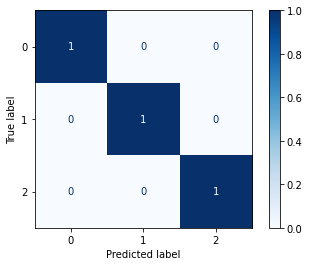

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
_ = plot_confusion_matrix(model, x_test, y_pred, cmap='Blues')#, normalize = 'true')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Dividindo x e y
x = data.drop(columns="ind_atrito")
y = data['ind_atrito']

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.3, 
                                                    random_state = 42)

# Treinando o modelo
model = LogisticRegression().fit(x_train, y_train)

# Fazendo as predições
y_pred = model.predict(x_test)

###Matriz de confusão


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
_ = plot_confusion_matrix(model, x_test, y_pred, cmap='Blues')#, normalize = 'true')